# Project 1: GANs for hand-written numbers

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device='cuda'
batch_size=128
noise_dim=64

#optimizer parameters

lr=0.0002
beta_1=0.5
beta_2=0.99

#training variables
epochs=20

In [ ]:
#load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

train_augs=T.Compose([T.RandomRotation((-20,20)),
                      T.ToTensor() # (h, w, c)->(c, h, w)
                      ])

trainset=datasets.MNIST('MNIST/',download=True, train=True,transform=train_augs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



number of images in trainset: 60000


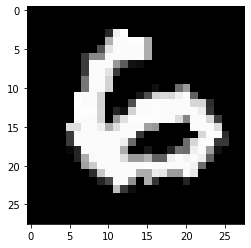

In [ ]:
image,label=trainset[9000]
plt.imshow(image.squeeze(),cmap='gray')
print("number of images in trainset:", len(trainset))

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
print('number of batchs in trainloader:', len(trainloader))

number of batchs in trainloader: 469


In [ ]:
# display images:
def show_tensor_images(tensor_img,num_img=16,size=(1,28,28)):
  unflat_img = tensor_img.detach().cpu()
  img_grid = make_grid(unflat_img[:num_img], nrow = 4)
  plt.imshow(img_grid.permute(1,2,0).squeeze())
  plt.show()

## Discriminator Network
Binary classifier that classifies an image into fake or real. 


In [ ]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

In [ ]:
#input (batch_size,1,28,28)
def get_disc_block(in_channels,out_channels,kernel_size,stride):

  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.block1 = get_disc_block(1, 16, (3,3), 2)
    self.block2 = get_disc_block(16, 32, (5,5), 2)
    self.block3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self,images):
    x1=self.block1(images)
    x2=self.block2(x1)
    x3=self.block3(x2)

    x4=self.flatten(x3)
    x5=self.linear(x4)

    return x5 #with binary cross entropy with logic loss takes raw inputs, so we dont need sigmoid.


In [ ]:
D_network = Discriminator()
D_network.to(device)
summary(D_network,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Generator Network

In [ ]:
#input: batch,channel,h,w -> (bs,64,1,1)

def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):

  if final_block:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride),
      nn.Tanh()
    )

  else:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim
    self.block1 = get_gen_block(noise_dim,256,(3,3),2)
    self.block2 = get_gen_block(256,128,(4,4),1)
    self.block3 = get_gen_block(128,64,(3,3),2)

    self.final_block=get_gen_block(64,1,(4,4),2,final_block=True)
    # self.last_conv=nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = kernel_size, stride = stride),
    # self.tanh=nn.Tanh()

  def forward(self,random_noise_vector):
    #vector shape: (bs,noise_dim) -> (bs,noise_dim,1,1)
    x=random_noise_vector.view(-1, self.noise_dim, 1, 1)

    x=self.block1(x)
    x=self.block2(x)
    x=self.block3(x)
    x=self.final_block(x)

    return x

In [ ]:
G_network=Generator(noise_dim)
G_network.to(device)
summary(G_network,input_size=(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# not sure why but we change the random initialized weights for Normal weights
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m,nn.BatchNorm2d):
    nn.init.normal_(m.weight, 0.0, 0.2)
    nn.init.constant_(m.bias,0)

In [ ]:
D_network.apply(weights_init)
G_network.apply(weights_init)
print()

# Train networks


In [ ]:
# real_loss
def real_loss(D_predictions):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(D_predictions)
  loss = criterion(D_predictions, ground_truth)
  return loss

# fake_loss
def fake_loss(G_predictions):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(G_predictions)
  loss = criterion(G_predictions, ground_truth)
  return loss

In [ ]:
D_optimizer = torch.optim.Adam(D_network.parameters(), lr=lr, betas=(beta_1,beta_2))
G_optimizer = torch.optim.Adam(G_network.parameters(), lr=lr, betas=(beta_1,beta_2))

Epoch: 1 | D_loss: 0.59724833767043 | G_loss: 0.8133150177723818


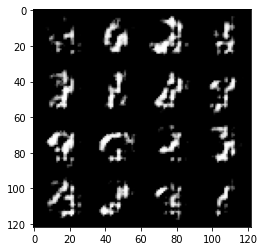

Epoch: 2 | D_loss: 0.5713104172301954 | G_loss: 0.8623224290957583


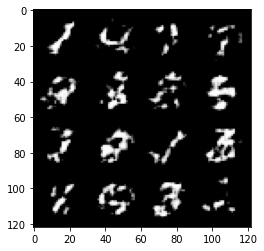

Epoch: 3 | D_loss: 0.5388592583919639 | G_loss: 0.9303023807529701


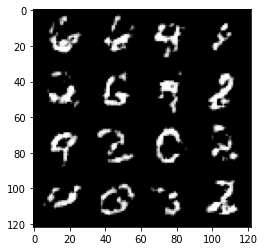

Epoch: 4 | D_loss: 0.5160769403997515 | G_loss: 0.9911750128020101


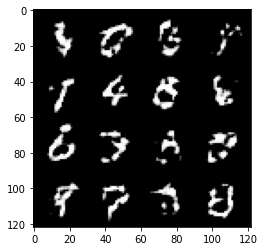

Epoch: 5 | D_loss: 0.5085607027448317 | G_loss: 1.0253038389850526


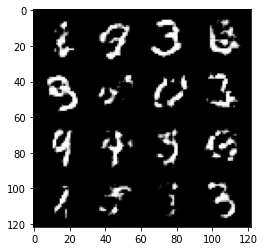

Epoch: 6 | D_loss: 0.5054290749625102 | G_loss: 1.0548496533558567


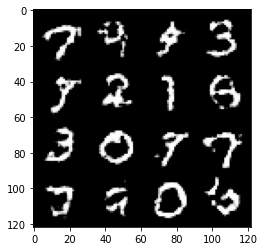

Epoch: 7 | D_loss: 0.51460069468789 | G_loss: 1.0525188587113483


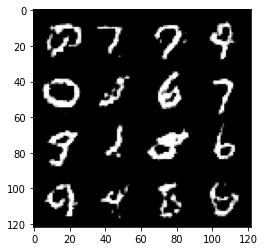

Epoch: 8 | D_loss: 0.5217322353233915 | G_loss: 1.0501015606973725


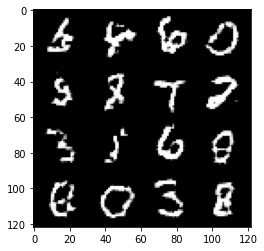

Epoch: 9 | D_loss: 0.4941154537297515 | G_loss: 1.1185169976149032


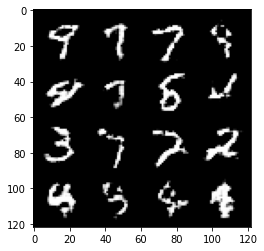

Epoch: 10 | D_loss: 0.46794486941813407 | G_loss: 1.2016474496581153


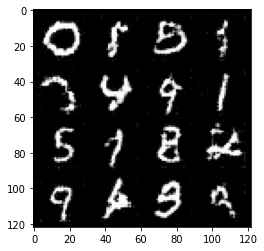

Epoch: 11 | D_loss: 0.5568707577074006 | G_loss: 1.0208336708388095


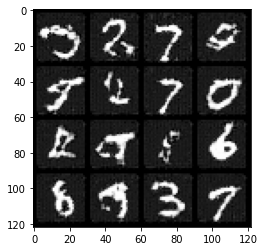

Epoch: 12 | D_loss: 0.5624879352700736 | G_loss: 1.0080698236727765


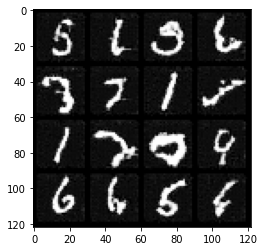

Epoch: 13 | D_loss: 0.5748621219002616 | G_loss: 0.9825994578251707


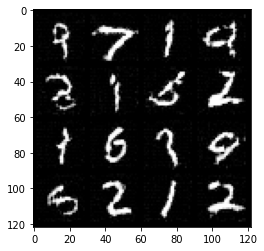

Epoch: 14 | D_loss: 0.5852216520289114 | G_loss: 0.9590911721624037


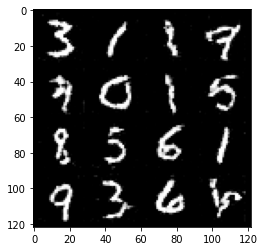

Epoch: 15 | D_loss: 0.5957693857933158 | G_loss: 0.9406024014263519


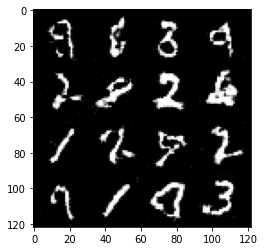

Epoch: 16 | D_loss: 0.6043577935141541 | G_loss: 0.9301031184857333


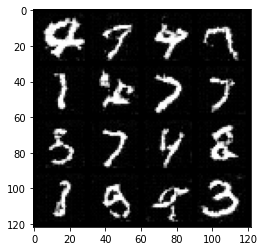

Epoch: 17 | D_loss: 0.6100565872466894 | G_loss: 0.9121287683688247


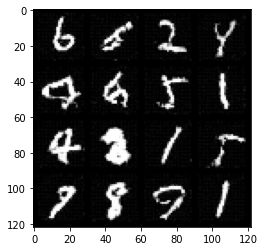

Epoch: 18 | D_loss: 0.6164653585917914 | G_loss: 0.9042014168269599


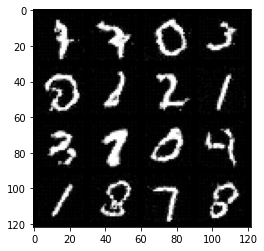

Epoch: 19 | D_loss: 0.6226710375946468 | G_loss: 0.886885855497836


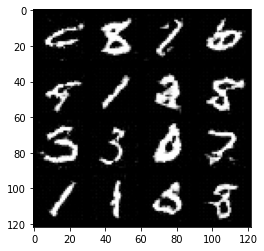

Epoch: 20 | D_loss: 0.6257959005675082 | G_loss: 0.8798664893422808


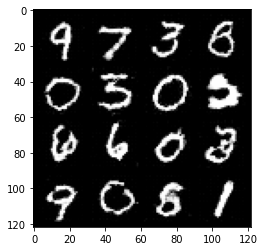

In [ ]:
# training loop

for i in range(epochs):
  total_d_loss = 0
  total_g_loss = 0

  for real_img,_ in trainloader:
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    # find loss and update discriminator's weights
    D_optimizer.zero_grad()

    fake_img = G_network(noise)
    D_pred = D_network(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D_network(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_real_loss + D_fake_loss)/2
    total_d_loss += D_loss.item()
    
    D_loss.backward()
    D_optimizer.step()

    # find loss and update generator's weights
    G_optimizer.zero_grad()

    noise=torch.randn(batch_size, noise_dim, device = device)

    fake_image = G_network(noise)
    D_pred = D_network(fake_image)

    #pass to the real loss because we want these images to "look" real after training
    G_loss = real_loss(D_pred)
    total_g_loss+=G_loss.item()

    G_loss.backward()
    G_optimizer.step()
  
  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print(f"Epoch: {i+1} | D_loss: {avg_d_loss} | G_loss: {avg_g_loss}")

  show_tensor_images(fake_img)

